In [1]:
# Imports 
import os
import sys
sys.path.append("..")
os.environ["pyna_language"] = 'python'
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import matplotlib.pyplot as plt
%matplotlib inline
from pyNA.pyna import pyna

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import scipy

In [2]:
py = pyna()
py.ac_name = 'stca'
py.initialize()
py.airframe.get_aerodynamics_deck()

In [3]:
# Create aerodynamics cubic interpolants 
A  = np.zeros(np.size(py.airframe.aero['alpha'])*np.size(py.airframe.aero['theta_flaps'])*np.size(py.airframe.aero['theta_slats']))
TF = np.zeros(np.size(py.airframe.aero['alpha'])*np.size(py.airframe.aero['theta_flaps'])*np.size(py.airframe.aero['theta_slats']))
TS = np.zeros(np.size(py.airframe.aero['alpha'])*np.size(py.airframe.aero['theta_flaps'])*np.size(py.airframe.aero['theta_slats']))
CL = np.zeros(np.size(py.airframe.aero['alpha'])*np.size(py.airframe.aero['theta_flaps'])*np.size(py.airframe.aero['theta_slats']))
CD = np.zeros(np.size(py.airframe.aero['alpha'])*np.size(py.airframe.aero['theta_flaps'])*np.size(py.airframe.aero['theta_slats']))

cntr = -1
for i, a in enumerate(py.airframe.aero['alpha']):
    for j, tf in enumerate(py.airframe.aero['theta_flaps']):
        for k, ts in enumerate(py.airframe.aero['theta_slats']):
            cntr = cntr + 1
            A[cntr] = a
            TF[cntr] = tf
            TS[cntr] = ts
            CL[cntr] = py.airframe.aero['c_l'][i,j,k]
            CD[cntr] = py.airframe.aero['c_d'][i,j,k]
            
f_LD = scipy.interpolate.Rbf(A, TF, TS, CL/CD, function='cubic')
f_D = scipy.interpolate.Rbf(A, TF, TS, CD, function='cubic')

f_alpha = scipy.interpolate.Rbf(TS, TF, CL, A, function='cubic')

In [16]:
# Compute angle of attack to fly at different speeds for NASA STCA
V = np.array([197, 250])*0.5144444
CL = (9.81*55000)/(0.5*1.225*V**2*150.41)

alpha_v = np.zeros((2,np.size(py.airframe.aero['theta_flaps'])))
ld_v = np.zeros((2,np.size(py.airframe.aero['theta_flaps'])))
for i, cli in enumerate(CL):
    for j, tf in enumerate(py.airframe.aero['theta_flaps']):
        alpha_v[i,j] = f_alpha(-6, tf, cli)
        ld_v[i,j] = f_LD(alpha_v[i,j], tf, -6)

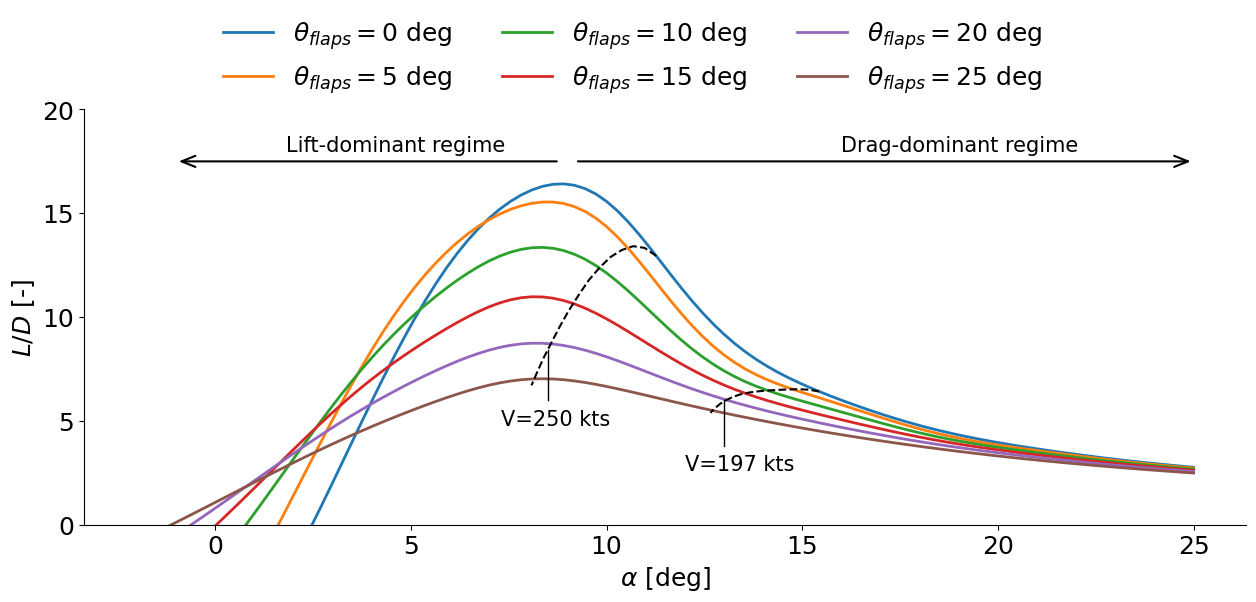

In [90]:
# Plot figure 
fig, ax = plt.subplots(1,1, figsize=(15,5.5))
plt.style.use('plot.mplstyle')

alpha = np.linspace(-2, 25, 100)

for th_flaps in [0, 5, 10, 15, 20, 25]:
    ld = f_LD(alpha, th_flaps*np.ones(np.size(alpha)), -6*np.ones(np.size(alpha)))
    plt.plot(alpha, ld, label=r'$\theta_{flaps}=$'+str(th_flaps)+' deg')
    
plt.annotate('', xy=(-1, 17.5), xycoords='data', xytext=(8.8, 17.5), textcoords='data',
             arrowprops=dict(arrowstyle="->, head_length=1., head_width=0.4", connectionstyle="arc3", lw=1.5), )
        
plt.annotate('', xy=(25, 17.5), xycoords='data', xytext=(9.2, 17.5), textcoords='data',
             arrowprops=dict(arrowstyle="->, head_length=1., head_width=0.4", connectionstyle="arc3", lw=1.5), )
        
plt.annotate(xy=(1.8,18), text='Lift-dominant regime', fontsize=15)
plt.annotate(xy=(16,18), text='Drag-dominant regime', fontsize=15)
    
# Plot speeds
for i, cli in enumerate(CL):

    if i == 0:
        marker = '--'
    elif i == 1:
        marker = '--'

    plt.plot(alpha_v[i,:], ld_v[i,:], marker, color='k', linewidth=1.5)
        
plt.annotate(xy=(7.3, 4.8), text='V=250 kts', fontsize=15)
plt.annotate(xy=(12, 2.6), text='V=197 kts', fontsize=15)

plt.plot([8.5, 8.5],[6., 8.4], 'k-', linewidth=1)
plt.plot([13, 13],[3.8, 6.], 'k-', linewidth=1)
    
plt.ylim([0, 20])
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$L/D$ [-]')
plt.legend(frameon=False, loc='lower left', bbox_to_anchor=(0.1,0.98), ncol=3)

plt.yticks([0, 5, 10, 15, 20])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)